In [1]:
# %pip install -r requirements.txt

Note:<br>
This demo is adapted from the LXMERT Demo present here: https://github.com/huggingface/transformers/tree/main/examples/research_projects/lxmert
<br>and VisualBERT VQA Demo present here: https://github.com/huggingface/transformers/tree/main/examples/research_projects/visual_bert

## Import

In [2]:
import PIL
import io
import torch
import numpy as np
import pandas as pd
import utils
import json

In [3]:
from utils import Config
from IPython.display import Image, display
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN

from evaluate import load
from datasets import load_dataset
from tokenizers import Tokenizer
from transformers import (
    AutoModelForSeq2SeqLM,
    DataCollatorWithPadding,
    PreTrainedTokenizerFast,
    Trainer,
    TrainingArguments,
    VisualBertForPreTraining,
)

In [4]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device, "; cuda:", CUDA_VERSION)
print("torch:", TORCH_VERSION)

device: cuda:0 ; cuda: cu117
torch: 1.13


## Setup

In [5]:
# load models and model components
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

image_preprocess = Preprocess(frcnn_cfg)

visualbert_pre = VisualBertForPreTraining.from_pretrained("uclanlp/visualbert-vqa-coco-pre")

bleu = load("bleu")

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/dhiya/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [6]:
wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file="model/tokenizer.json",
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

model_text = AutoModelForSeq2SeqLM.from_pretrained("model/stone-seq2seq")

In [7]:
# for visualizing frcnn output
def showarray(a, fmt="jpeg"):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [8]:
# run frcnn
def run_frcnn(URL):
    images, sizes, scales_yx = image_preprocess(URL)
    output_dict = frcnn(
        images,
        sizes,
        scales_yx=scales_yx,
        padding="max_detections",
        max_detections=frcnn_cfg.max_detections,
        return_tensors="pt",
    )
    return output_dict

In [9]:
# get unique word from text
def format_unique_word(text):
    words = text.split()
    return " ".join(sorted(set(words), key=words.index))

# formatting caption
def formating_text(captions):
    flat_text = " ".join(captions)
    return format_unique_word(flat_text)

## Load captions

In [10]:
captions = pd.read_csv('dataset/caption.txt', sep=';')

print(captions.shape[0])
captions.head(10)

660


image                                            caption
0  1.jpg  Singkapan batuan sedimen klastik dengan bidang...
1  1.jpg  Singkapan batuan sedimen klastik dengan bidang...
2  1.jpg  Singkapan batuan sedimen klastik dan batulumpu...
3  1.jpg  batulumpur karbonatan dan Singkapan batuan sed...
4  1.jpg  Singkapan batuan sedimen klastik dengan bidang...
5  2.jpg                                      Pecahan koral
6  2.jpg                                      Pecahan koral
7  2.jpg                                      Pecahan koral
8  2.jpg                                      Pecahan koral
9  2.jpg                                      Pecahan koral

<b>-- Skip line below if you have the metadata images files --
<br>Line below for generate metadata image files</b>

In [11]:
caption_group = captions.groupby('image').agg(', '.join)

metadata_item = []
for index, row in caption_group.iterrows():
    obj = {"file_name": row.name, "text": row.caption}
    metadata_item.append(obj)

metadata_item

[{'file_name': '1.jpg',
  'text': 'Singkapan batuan sedimen klastik dengan bidang perlapisan yang tidak tegas, batulumpur karbonatan, masif, retak-retak, sebagian hancur dan mulai lapuk, Singkapan batuan sedimen klastik dengan bidang perlapisan yang tidak tegas, masif, retak-retak, sebagian hancur sehingga mulai lapuk dan batulumpur karbonatan, Singkapan batuan sedimen klastik dan batulumpur karbonatan , batulumpur karbonatan dan Singkapan batuan sedimen klastik, Singkapan batuan sedimen klastik dengan bidang perlapisan yang tidak tegas dan batulumpur karbonatan'},
 {'file_name': '10.jpg',
  'text': 'Singkapan batuan sedimen klastik dengan bidang perlapisan yang baik, perselingan batugamping cherty dengan serpih, retak-retak, perlapisan tegas, Singkapan Batugamping cherty serpih, Singkapan batuan sedimen klastik dengan bidang perlapisan yang baik, perselingan batugamping cherty dengan serpih, retak-retak, perlapisan tegas, Singkapan Batugamping cherty serpih, Singkapan batuan sedimen k

In [12]:
with open("metadata.jsonl", 'w') as f:
    for item in metadata_item:
        f.write(json.dumps(item) + "\n")

## Train model

<b>-- Skip line below if you have the trained model files --
<br>Line below for training the VisualBERT model</b>

In [13]:
dataset = load_dataset(
    "imagefolder",
    data_files={"train": "dataset/folder/train/**", "test": "dataset/folder/test/**"},
)

Resolving data files:   0%|          | 0/113 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Using custom data configuration default-b042578067b5d1d0
Found cached dataset imagefolder (/home/dhiya/.cache/huggingface/datasets/imagefolder/default-b042578067b5d1d0/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
def preprocess_function(examples):
    text_caption = format_unique_word(examples["text"])

    output_dict = run_frcnn(examples["image"])
    features = output_dict.get("roi_features")
    
    inputs = wrapped_tokenizer(
        text_caption,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
    )

    visual_embeds = features.squeeze(0).squeeze(0)
    visual_attention_mask = torch.ones(features.shape[:-1]).squeeze(0)
    
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_attention_mask": visual_attention_mask,
        }
    )
    
    max_length = len(inputs["input_ids"]) + features.shape[-2]
    labels = wrapped_tokenizer(
        text_caption, padding="max_length", max_length=max_length
    )["input_ids"]
    sentence_image_labels = torch.tensor(1).unsqueeze(0)  # Batch_size
    
    feats_info = {"labels":labels, "sentence_image_labels":sentence_image_labels}
    inputs.update(feats_info)
    return inputs

datasets_encoded_train = dataset["train"].map(preprocess_function)
datasets_encoded_test = dataset["test"].map(preprocess_function)

  0%|          | 0/112 [00:00<?, ?ex/s]

/home/dhiya/miniconda3/envs/visualbert-demo3.8/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/20 [00:00<?, ?ex/s]

In [15]:
training_args = TrainingArguments(
    output_dir="./trainer/results",
    logging_dir="./trainer/logs",
    num_train_epochs=100,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
)

data_collator = DataCollatorWithPadding(tokenizer=wrapped_tokenizer)

trainer = Trainer(
    model=visualbert_pre,
    args=training_args,
    train_dataset=datasets_encoded_train,
    eval_dataset=datasets_encoded_test,
    tokenizer=wrapped_tokenizer,
    data_collator=data_collator,
)

In [16]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
/home/dhiya/miniconda3/envs/visualbert-demo3.8/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 112
  Num Epochs = 100
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1400
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a metho

The following columns in the evaluation set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The follow

  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num exam

***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Runn

***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Runn

***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1400, training_loss=0.3398571480384895, metrics={'train_runtime': 379.5617, 'train_samples_per_second': 29.508, 'train_steps_per_second': 3.688, 'total_flos': 118062889728000.0, 'train_loss': 0.3398571480384895, 'epoch': 100.0})

In [17]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


{'eval_loss': 0.8941537141799927,
 'eval_runtime': 0.3852,
 'eval_samples_per_second': 51.923,
 'eval_steps_per_second': 7.788,
 'epoch': 100.0}

In [18]:
predicts = trainer.predict(datasets_encoded_test)
len(predicts.predictions[0])

test_predictions = predicts.predictions[0].argmax(-1)

for i, item in enumerate(test_predictions):
    print(f"\nPrediction {i+1}:\n {wrapped_tokenizer.decode(item)}\n")

The following columns in the test set don't have a corresponding argument in `VisualBertForPreTraining.forward` and have been ignored: text, image. If text, image are not expected by `VisualBertForPreTraining.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 20
  Batch size = 8



Prediction 1:
 [CLS] singkapan batuan sedimen klastik dengan bidang perlapisan yang tidak tegas, batulumpur karbonatan, masif, retak - porfiritik [PAD], [PAD], hancur, retak [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


Prediction 2:
 [CLS] andesit berwarna coklat yang bertekstur porfiritik, porfiritik, batuan [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


Prediction 3:
 [CLS] batugamping, warna kelabu kehijauan, dan mudstone, batugamping mudstone [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [19]:
trainer.save_model("model/stone-visualbert")

Saving model checkpoint to model/stone-visualbert
Configuration saved in model/stone-visualbert/config.json
Model weights saved in model/stone-visualbert/pytorch_model.bin
tokenizer config file saved in model/stone-visualbert/tokenizer_config.json
Special tokens file saved in model/stone-visualbert/special_tokens_map.json


## Predictions

In [11]:
trained_model = VisualBertForPreTraining.from_pretrained("model/stone-visualbert")

In [12]:
def test_visualbert_model(image_feature, caption):
    inputs = wrapped_tokenizer(
        caption,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

    inputs.update(
        {
            "visual_embeds": image_feature,
            "visual_attention_mask": torch.ones(image_feature.shape[:-1]),
            "output_attentions": False,
        }
    )

    max_length = inputs["input_ids"].shape[-1] + image_feature.shape[-2]
    labels = wrapped_tokenizer(
        caption, return_tensors="pt", padding="max_length", max_length=max_length
    )["input_ids"]
    sentence_image_labels = torch.tensor(1).unsqueeze(0)  # Batch_size

    outputs = trained_model(
        **inputs,
        labels=labels,
        sentence_image_labels=sentence_image_labels,
    )
    
    return outputs

In [13]:
def greedy_search(text):
    input_ids = wrapped_tokenizer.encode(text, return_tensors='pt')

    # generate text until the output length (which includes the context length) reaches 20
    greedy_output = model_text.generate(input_ids, max_length=20)
    
    output = wrapped_tokenizer.decode(greedy_output[0], skip_special_tokens=True)
    
    return output

In [14]:
data_test_path = 'dataset/Flickr8K_Text/Flickr_8k.testImages.txt'

my_file = open(data_test_path, "r")
data = my_file.read()
test_list = data.split("\n")
my_file.close()

File :  1.jpg


/home/dhiya/miniconda3/envs/visualbert-demo3.8/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


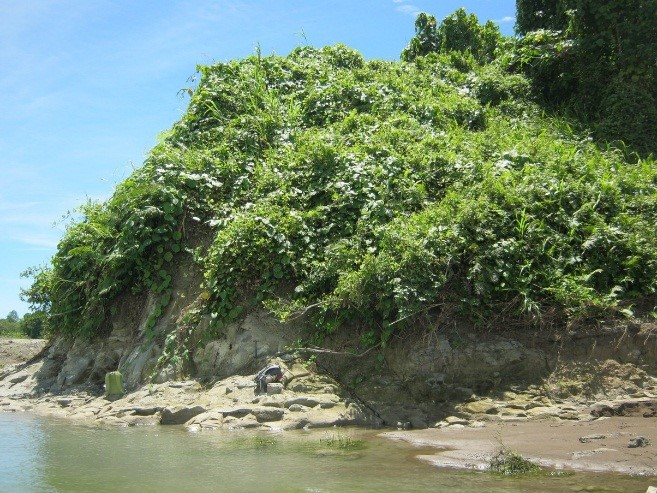

Caption:
1. Singkapan batuan sedimen klastik dengan bidang perlapisan yang tidak tegas, batulumpur karbonatan, masif, retak-retak, sebagian hancur dan mulai lapuk
2. Singkapan batuan sedimen klastik dengan bidang perlapisan yang tidak tegas, masif, retak-retak, sebagian hancur sehingga mulai lapuk dan batulumpur karbonatan
3. Singkapan batuan sedimen klastik dan batulumpur karbonatan
4. batulumpur karbonatan dan Singkapan batuan sedimen klastik
5. Singkapan batuan sedimen klastik dengan bidang perlapisan yang tidak tegas dan batulumpur karbonatan

Formatted caption:
 Singkapan batuan sedimen klastik dengan bidang perlapisan yang tidak tegas, batulumpur karbonatan, masif, retak-retak, sebagian hancur dan mulai lapuk sehingga karbonatan tegas

Prediction:
 singkapan batuan sedimen klastik dengan bidang perlapisan yang tidak tegas, batulumpur karbonatan, masif, retak - porfiritik,, hancur, retak

Greedy search:
 singkapan batuan sedimen klastik dengan bidang perlapisan yang tidak tegas, b

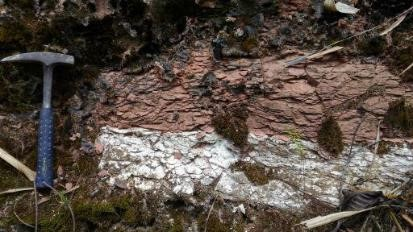

Caption:
1. Batugamping dengan sisipan serpih
2. batugamping pasiran berwarna merah bata/kecoklatan
3. batugamping pasiran berwarna merah bata/kecoklatan menindih batugamping pasiran berwarna kelabu cerah
4. Batugamping bersisipan serpih dan batugamping pasiran berwarna kelabu cerah
5. Batugamping bersisipan serpih dan batugamping pasiran berwarna kelabu cerah cenderung menyerpih

Formatted caption:
 Batugamping dengan sisipan serpih batugamping pasiran berwarna merah bata/kecoklatan menindih kelabu cerah bersisipan dan cenderung menyerpih

Prediction:
 batugamping dengan sisipan serpih batugamping pasiran berwarna merah bata kecoklatan menindih kelabu cerah cerah dan cenderung menyerpih cerah cenderung bersisipan cenderung bersisipan cerah

Greedy search:
 batugamping dengan sisipan serpih batugamping pasiran berwarna merah bata kecoklatan menindih kelabu cerah cerah dan cenderung menyerpih cerah

BLEU Score:
 {'bleu': 0.25153803595170526, 'precisions': [0.7777777777777778, 0.41176470

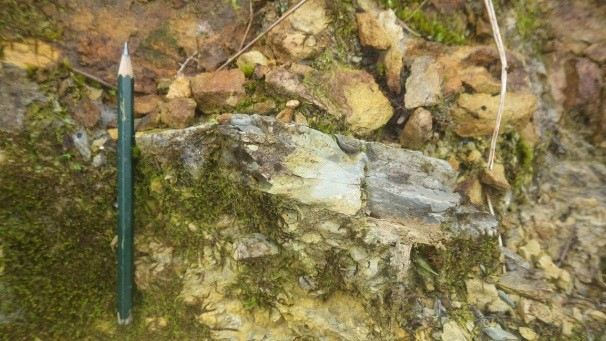

Caption:
1. Batugamping dengan sisipan serpih berwarna kelabu
2. Batugamping
3. Batugamping besisipan serpih berwarna kelabu dan lempung lanauan
4. Singkapan Batugamping pasiran berwarna kelabu kecoklatan dan lempung lanuaan
5. Batugamping dengan sisipan serpih

Formatted caption:
 Batugamping dengan sisipan serpih berwarna kelabu besisipan dan lempung lanauan Singkapan pasiran kecoklatan lanuaan

Prediction:
 batugamping dengan sisipan serpih berwarna kelabu lanau dan lempung lanauan singkapan pasiran kecoklatan lanau

Greedy search:
 batugamping dengan sisipan serpih berwarna kelabu lanau dan lempung lanauan singkapan pasiran kecoklatan lanau

BLEU Score:
 {'bleu': 0.2737928561916526, 'precisions': [0.6428571428571429, 0.38461538461538464, 0.25, 0.09090909090909091], 'brevity_penalty': 1.0, 'length_ratio': 4.666666666666667, 'translation_length': 14, 'reference_length': 3}

----------------------------------------------------------------------------------------------------

File :  1

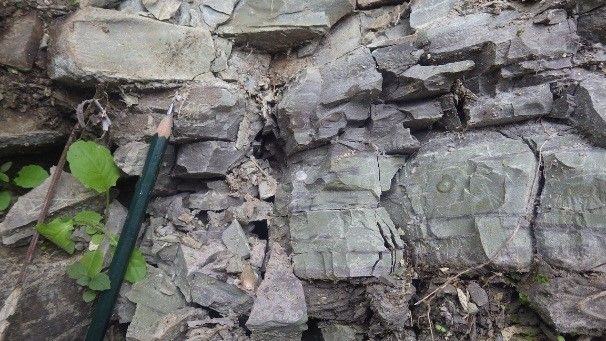

Caption:
1. Batugamping, warna kelabu kehijauan, dan mudstone
2. Batugamping kelabu kehijauan, dan mudstone
3. Batugamping dan mudstone
4. Batugamping, warna kelabu kehijauan, dan mudstone
5. Batugamping, warna kelabu dan mudstone

Formatted caption:
 Batugamping, warna kelabu kehijauan, dan mudstone Batugamping

Prediction:
 batugamping, warna kelabu kehijauan, dan mudstone batugamping

Greedy search:
 batugamping, warna kelabu kehijauan, dan mudstone batugamping

BLEU Score:
 {'bleu': 0.5873949094699213, 'precisions': [0.6666666666666666, 0.625, 0.5714285714285714, 0.5], 'brevity_penalty': 1.0, 'length_ratio': 1.8, 'translation_length': 9, 'reference_length': 5}

----------------------------------------------------------------------------------------------------

File :  12.jpg


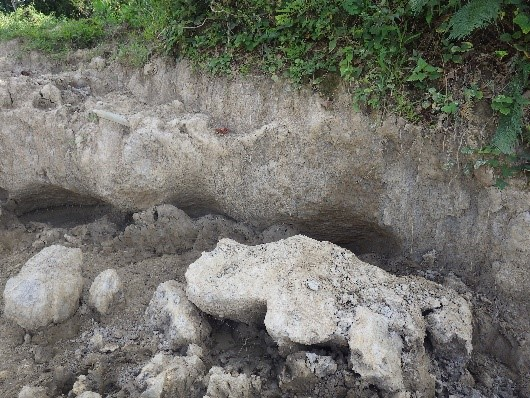

Caption:
1. Singkapan perselingan batupasir dengan konglomerat
2. Singkapan batupasir masif dengan ukuran butir pasir halus-lanau, warna segar abu-abu, warna lapuk abu-abu kecoklatan
3. Singkapan batupasir masif dan karbonatan
4. Singkapan perselingan batupasir dengan konglomerat dan karbonatan
5. Singkapan batupasir masif dengan ukuran butir pasir halus-lanau, warna segar abu-abu, warna lapuk abu-abu kecoklatan dan karbonatan

Formatted caption:
 Singkapan perselingan batupasir dengan konglomerat masif ukuran butir pasir halus-lanau, warna segar abu-abu, lapuk abu-abu kecoklatan dan karbonatan

Prediction:
 singkapan perselingan batupasir dengan konglomerat masif ukuran butir pasir halus - lanau, warna segar abu - abu,,

Greedy search:
 singkapan perselingan batupasir dengan konglomerat masif ukuran butir pasir halus - lanau, warna segar abu - abu

BLEU Score:
 {'bleu': 0.25448050157066204, 'precisions': [0.6111111111111112, 0.4117647058823529, 0.25, 0.06666666666666667], 'brevity_pen

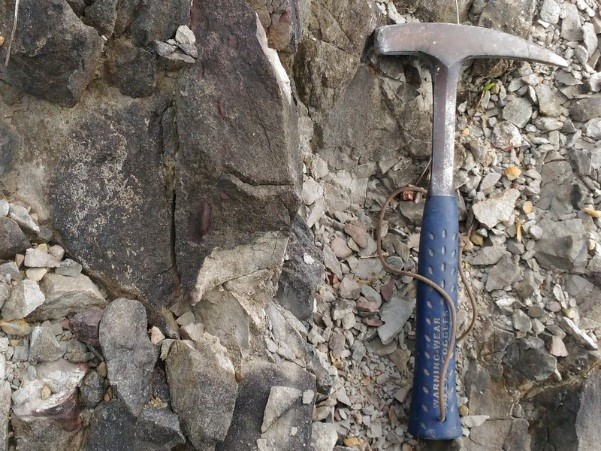

Caption:
1. Singkapan Batupasir
2. Batupasir, kompak, retak-retak, kelabu
3. Batupasir, kompak, retak-retak, kelabu
4. Singkapan Batupasir
5. Batupasir, kompak, retak-retak, kelabu

Formatted caption:
 Singkapan Batupasir Batupasir, kompak, retak-retak, kelabu

Prediction:
 singkapan batupasir batupasir, kompak, retak - retak, kelabu lapuk,,

Greedy search:
 singkapan batupasir batupasir, kompak, retak - retak, kelabu lapuk,,

BLEU Score:
 {'bleu': 0.0, 'precisions': [0.2857142857142857, 0.15384615384615385, 0.08333333333333333, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 3.5, 'translation_length': 14, 'reference_length': 4}

----------------------------------------------------------------------------------------------------

File :  30.jpg


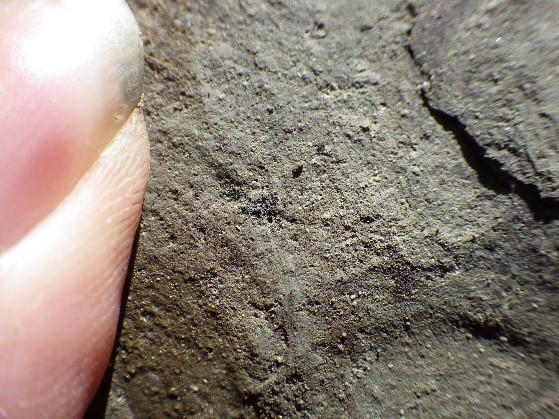

Caption:
1. fosil foraminifera, silica, karbon, sebagian terdapat komponen glaukonit berwarna kehijauan, getas, dan terkekarkan
2. fragmen-fragmen fosil foraminifera, silica, karbon, sebagian terdapat komponen glaukonit
3. fosil foraminifera, silica, karbon, sebagian terdapat komponen glaukonit berwarna kehijauan
4. fragmen-fragmen fosil foraminifera, silica, karbon, sebagian terdapat komponen glaukonit berwarna kehijauan, getas
5. fosil foraminifera, silica, karbon, sebagian terdapat komponen glaukonit berwarna kehijauan, getas,

Formatted caption:
 fosil foraminifera, silica, karbon, sebagian terdapat komponen glaukonit berwarna kehijauan, getas, dan terkekarkan fragmen-fragmen kehijauan getas

Prediction:
 fosil foraminifera, silica, karbon, sebagian terdapat komponen glaukonit berwarna kehijauan, getas, dan terkekarkan, kemerahan besar besar serpih bergelembung tegas

Greedy search:
 fosil foraminifera, silica, karbon, sebagian terdapat komponen glaukonit berwarna kehijauan, getas,

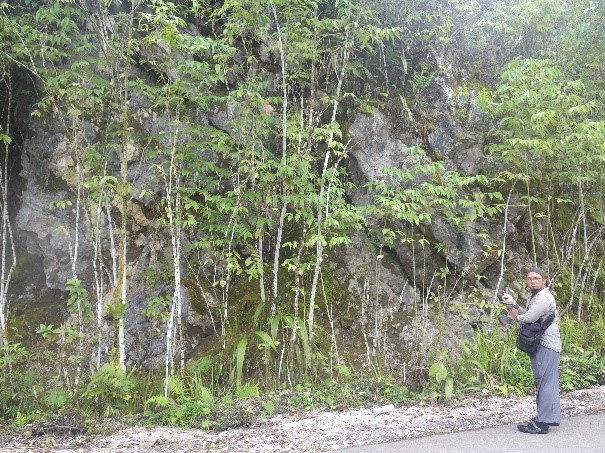

Caption:
1. Singkapan batugamping klastik berukuran butir lempungan (lanau-lempung) berwarna segar coklat tua
2. Singkapan batugamping berwarna segar coklat tua
3. Singkapan batugamping klastik dengan berukuran butir lempungan
4. Singkapan batugamping klastik berukuran butiran lempungan dan berwarna segar coklat tua
5. batugamping berwarna segar coklat tua

Formatted caption:
 Singkapan batugamping klastik berukuran butir lempungan (lanau-lempung) berwarna segar coklat tua dengan butiran dan

Prediction:
 singkapan batugamping klastik berukuran butir lempungan lempungan lanau - lempung lanau berwarna segar coklat tua dengan fanerik dan, batupasir,

Greedy search:
 singkapan batugamping klastik berukuran butir lempungan lempungan lanau - lempung lanau berwarna segar coklat tua dengan fanerik dan

BLEU Score:
 {'bleu': 0.28433291815307693, 'precisions': [0.5555555555555556, 0.35294117647058826, 0.25, 0.13333333333333333], 'brevity_penalty': 1.0, 'length_ratio': 2.5714285714285716, 'trans

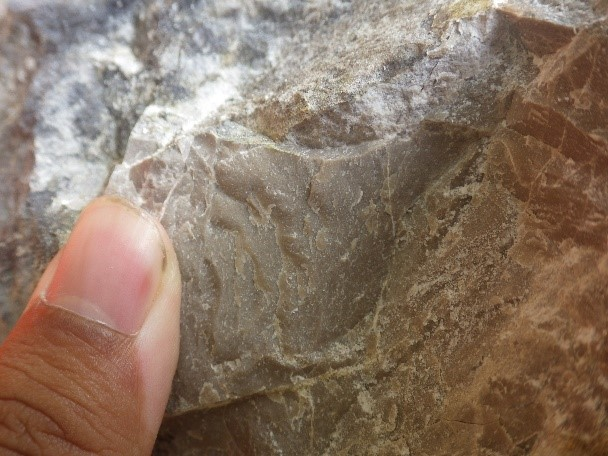

Caption:
1. Batugamping lempung-lanauan
2. Batugamping dan batu lempung-lanauan
3. Batugamping berlapis batu lempung-lanauan
4. Batugamping lempung-lanauan
5. Batugamping lempung-lanauan

Formatted caption:
 Batugamping lempung-lanauan dan batu berlapis

Prediction:
 batugamping lempung - lanauan dan batu berlapis

Greedy search:
 batugamping lempung - lanauan dan batu berlapis

BLEU Score:
 {'bleu': 0.0, 'precisions': [0.42857142857142855, 0.16666666666666666, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.75, 'translation_length': 7, 'reference_length': 4}

----------------------------------------------------------------------------------------------------

File :  37.jpg


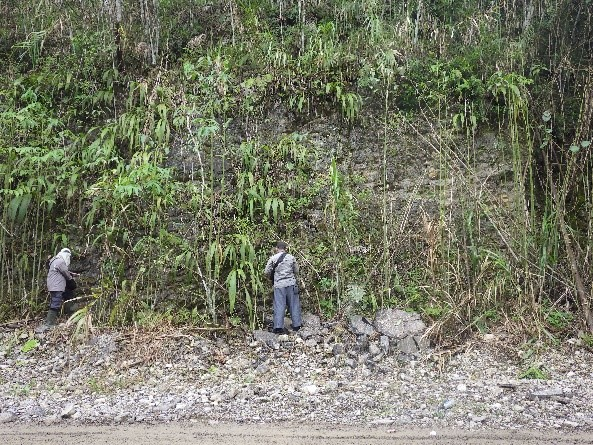

Caption:
1. Singkapan batugamping klastik dengan berukuran butir lempungan dengan lensa rijang hitam
2. Singkapan batugamping klastik dengan berukuran butir lempungan dengan lensa rijang hitam
3. Lensa rijang hitam dan Singkapan batugamping klastik dengan berukuran butir
4. Batugamping klastik dan rijang Hitam
5. Singkapan batugamping klastik dengan berukuran butir lempungan dengan lensa rijang hitam

Formatted caption:
 Singkapan batugamping klastik dengan berukuran butir lempungan lensa rijang hitam Lensa dan Batugamping Hitam

Prediction:
 singkapan batugamping klastik dengan berukuran butir lempungan lensa rijang hitam lensa dan batugamping hitam

Greedy search:
 singkapan batugamping klastik dengan berukuran butir lempungan lensa rijang hitam lensa dan batugamping hitam

BLEU Score:
 {'bleu': 0.4324227075463214, 'precisions': [0.7142857142857143, 0.5384615384615384, 0.3333333333333333, 0.2727272727272727], 'brevity_penalty': 1.0, 'length_ratio': 2.0, 'translation_length': 14, 'ref

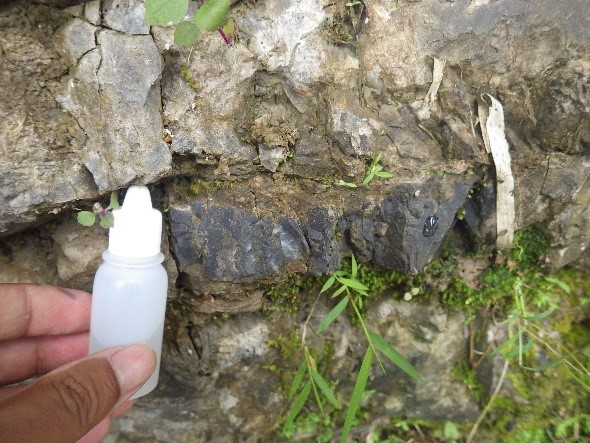

Caption:
1. Rijang hitam, retak-retak yang terisi oleh mineral silika, sebagian menunjukkan campuran karbonat berwarna putih
2. Rijang hitam, retak-retak yang terisi oleh mineral silika, sebagian menunjukkan campuran karbonat berwarna putih
3. Rijang hitam, retak-retak yang terisi oleh mineral silika, sebagian menunjukkan campuran karbonat berwarna putih
4. Lensa Rijang Hitam
5. Lensa Rijang Hitam

Formatted caption:
 Rijang hitam, retak-retak yang terisi oleh mineral silika, sebagian menunjukkan campuran karbonat berwarna putih Lensa Hitam

Prediction:
 rijang hitam, retak - retak yang terisi oleh mineral silika, sebagian menunjukkan campuran karbonat berwarna putih, lensa batupasir lensa

Greedy search:
 rijang hitam, retak - retak yang terisi oleh mineral silika, sebagian menunjukkan campuran karbonat berwarna putih

BLEU Score:
 {'bleu': 0.611904949990603, 'precisions': [0.7222222222222222, 0.6470588235294118, 0.5625, 0.5333333333333333], 'brevity_penalty': 1.0, 'length_ratio': 3.6

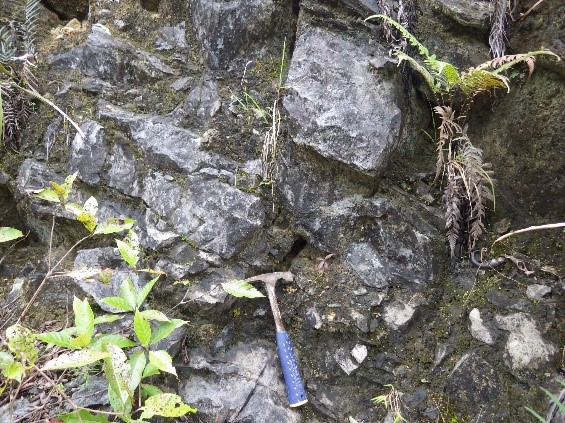

Caption:
1. Singkapan perselingan batupasir, rijang dan serpih
2. Singkapan perselingan batupasir, rijang dan serpih
3. Singkapan perselingan batupasir, rijang dan serpih
4. Singkapan perselingan batupasir, rijang dan serpih
5. Singkapan perselingan batupasir, rijang dan serpih

Formatted caption:
 Singkapan perselingan batupasir, rijang dan serpih

Prediction:
 singkapan perselingan batupasir, rijang dan serpih

Greedy search:
 singkapan perselingan batupasir, rijang dan serpih

BLEU Score:
 {'bleu': 0.461999336994571, 'precisions': [0.7142857142857143, 0.6666666666666666, 0.6, 0.5], 'brevity_penalty': 0.751477293075286, 'length_ratio': 0.7777777777777778, 'translation_length': 7, 'reference_length': 9}

----------------------------------------------------------------------------------------------------

File :  87.jpg


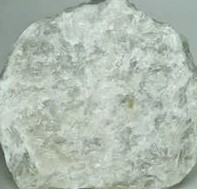

Caption:
1. Batuan pualam atau marmer berpita warna
2. Batuan pualam atau marmer adalah mempunyai pita-pita warna, kristal-kristalnya sedang
3. Batuan pualam atau marmer adalah mempunyai pita-pita warna, kristal-kristalnya kasar
4. Batuan pualam atau marmer berpita warna
5. Batuan pualam atau marmer adalah mempunyai pita-pita warna, kristal-kristalnya kasar

Formatted caption:
 Batuan pualam atau marmer berpita warna adalah mempunyai pita-pita warna, kristal-kristalnya sedang kasar

Prediction:
 batuan obsidian sangat marmer kekuningan warna adalah terlihat terlihat - gunung warna, kristal - gunung sedang kasar

Greedy search:
 batuan obsidian sangat marmer kekuningan warna adalah terlihat terlihat - gunung warna, kristal - gunung sedang kasar

BLEU Score:
 {'bleu': 0.0, 'precisions': [0.2222222222222222, 0.058823529411764705, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 2.25, 'translation_length': 18, 'reference_length': 8}

------------------------------------------------------

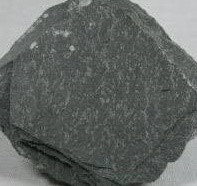

Caption:
1. Batuan sabak berwarna abu-abu kehijau-hijauan dan hitam
2. Batuan sabak berwarna abu-abu kehijau-hijauan dan hitam
3. Batuan sabak berwarna abu-abu kehijau-hijauan dan hitam
4. Batuan sabak berwarna abu-abu kehijau-hijauan dan hitam
5. Batuan sabak berwarna abu-abu kehijau-hijauan dan hitam

Formatted caption:
 Batuan sabak berwarna abu-abu kehijau-hijauan dan hitam

Prediction:
 batuan kuarsit berwarna abu - abu fanerik - keabuan dan hitam

Greedy search:
 batuan kuarsit berwarna abu - abu fanerik - keabuan dan hitam

BLEU Score:
 {'bleu': 0.0, 'precisions': [0.18181818181818182, 0.0, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.2222222222222223, 'translation_length': 11, 'reference_length': 9}

----------------------------------------------------------------------------------------------------

File :  89.jpg


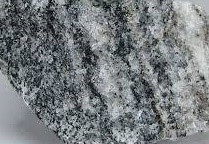

Caption:
1. Batuan Gneiss berwarna putih kebau-abuan, terdapat goresan-goresan yang tersusun dari minera-mineral
2. Batuan Gneiss berwarna putih kebau-abuan, bergoresan
3. Batuan Gneiss berwarna putih berbentuk penjajaran yang tipis
4. Batuan Geniss bentuk penjajaran yang tipis
5. Batuan Gneiss berwarna putih berbentuk penjajaran tipis, dan bergoresan

Formatted caption:
 Batuan Gneiss berwarna putih kebau-abuan, terdapat goresan-goresan yang tersusun dari minera-mineral bergoresan berbentuk penjajaran tipis Geniss bentuk tipis, dan

Prediction:
 batuan obsidian berwarna putih setempat - abuan, terdapat gunung - ringan yang ringan dari terapung - mineral serta

Greedy search:
 batuan obsidian berwarna putih setempat - abuan, terdapat gunung - ringan yang ringan dari terapung - mineral

BLEU Score:
 {'bleu': 0.0, 'precisions': [0.3333333333333333, 0.11764705882352941, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 2.25, 'translation_length': 18, 'reference_length': 8}

-------------

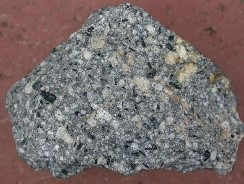

Caption:
1. Andesit berwarna abu-abu berbalutkan plagioklas dan penokris hornblende bertekstur kasar
2. Batuan Andesit bertekstur kasar
3. Andesit berwarna abu-abu berbalutkan plagioklas dan penokris hornblende
4. Batuan Andesit berwarna abu-abu
5. Batuan Andesit berwarna abu-abu dan bertekstur kasar

Formatted caption:
 Andesit berwarna abu-abu berbalutkan plagioklas dan penokris hornblende bertekstur kasar Batuan

Prediction:
 andesit berwarna abu - abu hijau plagioklas dan penokris hornblende bertekstur kasar batuan

Greedy search:
 andesit berwarna abu - abu hijau plagioklas dan penokris hornblende bertekstur kasar batuan

BLEU Score:
 {'bleu': 0.3026643726685863, 'precisions': [0.46153846153846156, 0.3333333333333333, 0.2727272727272727, 0.2], 'brevity_penalty': 1.0, 'length_ratio': 2.1666666666666665, 'translation_length': 13, 'reference_length': 6}

----------------------------------------------------------------------------------------------------

File :  105.jpg


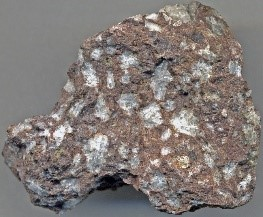

Caption:
1. Andesit berwarna coklat yang bertekstur porfiritik
2. Andesit bertekstur porfiritik
3. Andesit berwarna coklat
4. Andesit coklat yang bertekstur porfiritik
5. Batuan Andesit coklat bertekstur porfiritik

Formatted caption:
 Andesit berwarna coklat yang bertekstur porfiritik Batuan

Prediction:
 andesit berwarna coklat yang bertekstur porfiritik batuan

Greedy search:
 andesit berwarna coklat yang bertekstur porfiritik batuan

BLEU Score:
 {'bleu': 0.4111336169005197, 'precisions': [0.5714285714285714, 0.5, 0.4, 0.25], 'brevity_penalty': 1.0, 'length_ratio': 1.4, 'translation_length': 7, 'reference_length': 5}

----------------------------------------------------------------------------------------------------

File :  110.jpg


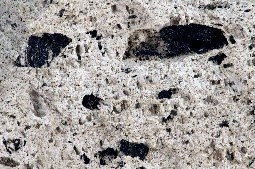

Caption:
1. Andesit berwarna abu-abu terang yang mengandung hornblende berwarna hitam dari lava gunung api
2. Andesit mengandung hornblende berwarna hitam dari lava gunung api
3. Andesit berwarna abu-abu terang dengan hornblende berwarna hitam dari lava gunung api
4. Andesit berwarna abu-abu terang dari lava gunung api mengandung hornblende berwarna hitam
5. Andesit dari lava gunung api mengandung hornblende berwarna hitam

Formatted caption:
 Andesit berwarna abu-abu terang yang mengandung hornblende hitam dari lava gunung api dengan

Prediction:
 andesit berwarna abu - abu terang yang mengandung hornblende hitam dari lava gunung api dengan

Greedy search:
 andesit berwarna abu - abu terang yang mengandung hornblende hitam dari lava gunung api dengan

BLEU Score:
 {'bleu': 0.4333207865423752, 'precisions': [0.7333333333333333, 0.5, 0.38461538461538464, 0.25], 'brevity_penalty': 1.0, 'length_ratio': 1.3636363636363635, 'translation_length': 15, 'reference_length': 11}

----------------

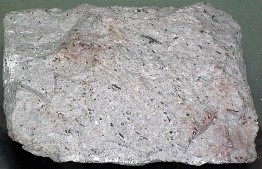

Caption:
1. Andesit berwarna abu terang yang mengandung kristal porfiritik
2. Andesit abu terang dengan krital porfiritik
3. Andesit berselingan dengan krital porfiritik
4. Andesit berwarna abu terang berbalut krital porfiritik
5. Andesit dengan balutan krital porfiritik

Formatted caption:
 Andesit berwarna abu terang yang mengandung kristal porfiritik dengan krital berselingan berbalut balutan

Prediction:
 andesit berwarna abu terang yang mengandung kristal porfiritik dengan krital berselingan berbalut balutan

Greedy search:
 andesit berwarna abu terang yang mengandung kristal porfiritik dengan krital berselingan berbalut balutan

BLEU Score:
 {'bleu': 0.46350238641438496, 'precisions': [0.8461538461538461, 0.5, 0.36363636363636365, 0.3], 'brevity_penalty': 1.0, 'length_ratio': 1.8571428571428572, 'translation_length': 13, 'reference_length': 7}

----------------------------------------------------------------------------------------------------

File :  117.jpg


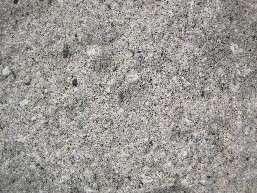

Caption:
1. Andesit berwarna abu-abu terang bertekstur kristal halus
2. Andesit warna abu terang bertekstur kristal halus
3. Andesit abu terang bertekstur kristal halus
4. Andesit bertekstur kristal halus
5. Batuan Andesit berwarna abu terang bertekstur kristal halus

Formatted caption:
 Andesit berwarna abu-abu terang bertekstur kristal halus warna abu Batuan

Prediction:
 andesit berwarna abu - abu terang bertekstur kristal halus warna abu batuan

Greedy search:
 andesit berwarna abu - abu terang bertekstur kristal halus warna abu batuan

BLEU Score:
 {'bleu': 0.2665837681702885, 'precisions': [0.5, 0.45454545454545453, 0.2, 0.1111111111111111], 'brevity_penalty': 1.0, 'length_ratio': 2.0, 'translation_length': 12, 'reference_length': 6}

----------------------------------------------------------------------------------------------------

Avg. BLEU Score: 0.33957107836195677


In [15]:
bleu_avg = 0.0

for file_name in test_list:
    print("File : ", file_name)

    image_caption = captions.loc[captions["image"] == file_name]["caption"]
    list_image_caption = [''.join(col).strip() for col in image_caption]
    formatted_image_caption = formating_text(list_image_caption)

    file_image_path = f'dataset/Flicker8k_Dataset/{file_name}'

    img = PIL.Image.open(file_image_path)

    output_dict = run_frcnn(img)
    image_feature = output_dict.get("roi_features")
    
    outputs_model = test_visualbert_model(image_feature, formatted_image_caption)

    prediction_logits = outputs_model.prediction_logits.argmax(-1)
    predict_caption = wrapped_tokenizer.decode(prediction_logits[0], skip_special_tokens=True)
    predict_caption_greedy = greedy_search(predict_caption)
    
    predictions = [predict_caption_greedy]
    references = [[[caption] for caption in list_image_caption]]
    bleu_result = bleu.compute(predictions=predictions, references=references)
    bleu_avg = bleu_avg + bleu_result["bleu"]

    display(img)

    print("Caption:")
    for i in range(len(list_image_caption)):
        print(f"{i+1}. {list_image_caption[i]}")

    print("\nFormatted caption:\n", formatted_image_caption)

    print(f"\nPrediction:\n {predict_caption}")
    
    print(f"\nGreedy search:\n {predict_caption_greedy}\n")
    
    print(f"BLEU Score:\n {bleu_result}\n")
    print(100 * '-' + "\n")

print(f"Avg. BLEU Score: {bleu_avg / len(test_list)}")